# CESM-LE analysis
### Looks and changes in Fire risk over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily TBOT, RH, & precip
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2021.01.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
# For use on Casper: ONLY RUN THIS CELL ONCE  
# note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18) 
#    to allow dask to allocate more memory to each worker"
ncores = 18
nmem   = str(int(375*ncores/ncores))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [9]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.30:33680 Dashboard: http://10.12.205.30/proxy/8787/status,Cluster Workers: 18 Cores: 18 Memory: 374.94 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [10]:
def get_file(ee,model,field,component,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        if yr<=2014:
            mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data
        else:
            mlist = sorted(glob.glob(topdir+'*BSSP370cmip6.f09_g17.LE2-13*')) # hack to get SSPs
        mm = mlist[ee]
        atm    = '/atm/proc/tseries/day_1/'
        lnd    = '/lnd/proc/tseries/day_1/'
        firstyear = 10*int(yr/10)
        if yr >= 2015:  # Beause SSPs are 2015-2024...
            firstyear = 10*int(yr/10)+5
        yy    = '.'+str(firstyear)+'0101-'+str(firstyear+9)+'1231.'

        if yr>2009:
            if yr<2014:
                yy = '.20100101-20141231.'
        if yr>=2095:
            yy = '.20950101-21001231.'
        if component == 'lnd': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
        if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
    return ff


In [11]:
def all_files(model,field,firstyear, component,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,component,0) for ee in range(nens)]
    else:
        if firstyear <= 2014:
            yrs = [*np.arange(firstyear,2009,10),2010]
        if firstyear > 2014:
            yrs = [*np.arange((firstyear),2094,10),2095]

        files = [[get_file(ee,'CESM2',field,component,yr) for yr in yrs] 
                 for ee in range(nens)]
        #print(files)
    return files

In [12]:
def get_daily(model,fields,firstyear, component,nens):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, component,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                # add chunks for time
                ds = xr.open_mfdataset(files[0],combine='by_coords',
                                       parallel=True,chunks={'time':500})
                tmp = xr.open_dataset(files[0][0],chunks={'time':500})
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0],chunks={'time':500})

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks={'time':500})
        ds[field] = tmp[field]

    if component == 'lnd':
        ds['landarea'] = ds['area']*ds['landfrac']
        ds['landarea'].name = 'landarea'
        ds['landarea'].attrs['units'] = 'km2'
        
    ndays = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [13]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### Actually read the data in here

In [14]:
%%time

lnd_vars = ['RAIN','SNOW']
model = 'CESM2'
fyHIST = 2010
fySSP  = 2095
component = 'lnd'
nens = 5  # read in 10 ensemble members for now
ds = get_daily(model,lnd_vars,fyHIST, component,nens)
dsSSP = get_daily(model,lnd_vars,fySSP, component,nens)
#print(ds)

atm_vars = ['TREFHT','RHREFHT']
component = 'atm'
ds_atm = get_daily(model,atm_vars,fyHIST, component,nens)
ds_atmSSP = get_daily(model,atm_vars,fySSP, component,nens)

#ds_atm['TREFHT','RHREFHT']

CPU times: user 1.78 s, sys: 174 ms, total: 1.96 s
Wall time: 7.88 s


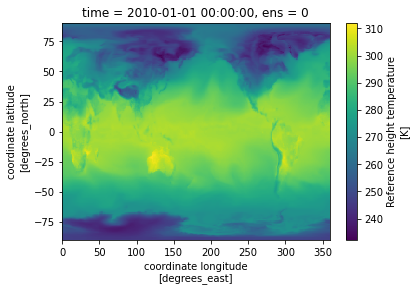

In [15]:
#force coordinate variables to match
ds_atm['lat'] = ds['lat']
ds_atm['lon'] = ds['lon']
ds[atm_vars[0]] = ds_atm[atm_vars[0]]
ds[atm_vars[1]] = ds_atm[atm_vars[1]]

ds_atmSSP['lat'] = dsSSP['lat']
ds_atmSSP['lon'] = dsSSP['lon']
dsSSP[atm_vars[0]] = ds_atmSSP[atm_vars[0]]
dsSSP[atm_vars[1]] = ds_atmSSP[atm_vars[1]]

ds[atm_vars[0]].isel(ens=0,time=0).plot();   

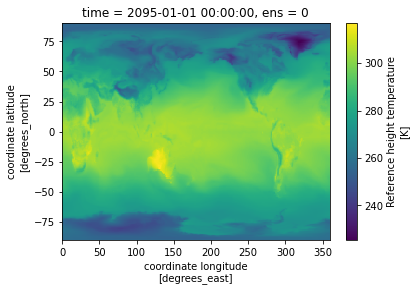

In [16]:
dsSSP[atm_vars[0]].isel(ens=0,time=0).plot();   

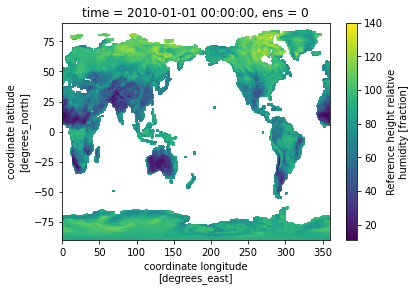

In [17]:
# sum rain + snow for precip.
ds['PPT'] = ds['RAIN']+ds['SNOW']
ds.PPT.attrs['units'] = ds.RAIN.attrs['units']
ds.PPT.attrs['long_name'] = 'Total Precip.'

dsSSP['PPT'] = dsSSP['RAIN']+dsSSP['SNOW']
dsSSP.PPT.attrs['units'] = dsSSP.RAIN.attrs['units']
dsSSP.PPT.attrs['long_name'] = 'Total Precip.'

# mask out oceans for temp and RH
ds = ds.where(ds['PPT'].max(['time','ens'])> 0.)
dsSSP = dsSSP.where(dsSSP['PPT'].max(['time','ens'])> 0.)
ds['RHREFHT'].isel(time=0,ens=0).plot();

In [18]:
# for speed, lets just look a single grid cell
plat, plon = 48,280  #-25, 150
#ds = ds.sel(lat=plat,lon=plon, method='nearest').load()

## If we're just looking at a single grid
#for i in range(nens):
#    plt.plot(ds.time,ds.PPT.isel(ens=i));

### Calculate Fire Danger Index
- acc_NI is the accumulated Nesterov fire danger index, which resets w/ daily precip > 3 mm 
- d_NI is the daily Nesterov fire danger index, calculated from temp, precip & RH
- from https://github.com/NGEET/fates/blob/master/fire/SFMainMod.F90

  - temp  = TREFHT (in C)
  - ppt   = PPT*sec_per_day (mm)
  - rh    = RHREFHT (fraction)
   
Nesterov Fire danger Index code in FATES: https://github.com/NGEET/fates/blob/8827a6ea77f0e4f5d8408ddd7eeaa776bb3bba8a/fire/SFMainMod.F90#L116-L162


In [19]:
# Fates_fire constants
# Nesterov from EQ 5 Thonicke et al 2010:
fdi_a = 17.62 
fdi_b = 243.12

ds['temp'] = ds['TREFHT'] - 273.15 #convert to degC
ds['rh'] = ds['RHREFHT']/100 # convert to fraction
ds['rh'] = ds['rh'].where(ds.rh<1,1) # set max rh=1

dsSSP['temp'] = dsSSP['TREFHT'] - 273.15 #convert to degC
dsSSP['rh'] = dsSSP['RHREFHT']/100 # convert to fraction
dsSSP['rh'] = dsSSP['rh'].where(dsSSP.rh<1,1) # set max rh=1
# mask out missing values (again)
ds = ds.where(ds['PPT'].max(['time','ens'])> 0.)
dsSSP = dsSSP.where(dsSSP['PPT'].max(['time','ens'])> 0.)

CPU times: user 612 ms, sys: 27.8 ms, total: 640 ms
Wall time: 4.44 s


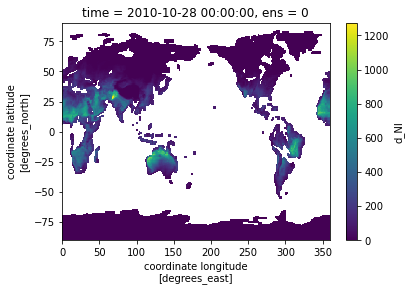

In [33]:
%%time
# these are the calculations that take forever!
# maybe it's not worth loading thse intermediate calculations into memory?  
yipsolon = (fdi_a* ds.temp)/(fdi_b+ ds.temp)+np.log(ds.rh) 
yipsolonSSP = (fdi_a* dsSSP.temp)/(fdi_b+ dsSSP.temp)+np.log(dsSSP.rh) 

#Standard met. formula
dewpoint = (fdi_b*yipsolon)/(fdi_a-yipsolon)
dewpointSSP = (fdi_b*yipsolonSSP)/(fdi_a-yipsolonSSP)

#follows Nesterov 1968.  Equation 5. Thonicke et al. 2010.
ds['d_NI'] = ((ds.temp-dewpoint)* ds.temp)#.compute(skipna=True) 
dsSSP['d_NI'] = ((dsSSP.temp-dewpointSSP)* dsSSP.temp)

# don't allow negative values
s2d = 3600*24
ds['d_NI'] = ds['d_NI'].where(ds['d_NI']>0,0)  
dsSSP['d_NI'] = dsSSP['d_NI'].where(dsSSP['d_NI']>0,0)  

# Reset when daily precip > 3 mm/day 
ds['d_NI'] = ds['d_NI'].where((ds.PPT*s2d)<3,np.nan)
dsSSP['d_NI'] = dsSSP['d_NI'].where((dsSSP.PPT*s2d)<3,np.nan)
ds['d_NI'].isel(ens=0,time=300).plot();


### Accumulate Nesterov index over the fire season
####  Reset when daily precip > 3 mm/day (set d_NI to nan) 

In [34]:
%%time
# for full grid
#ds['d_NI'] = ds['d_NI'].where((ds.PPT*s2d)<3,np.nan).compute(skipna=True)
#dsSSP['d_NI'] = dsSSP['d_NI'].where((dsSSP.PPT*s2d)<3,np.nan).compute(skipna=True)

# faster to select grid here
plat, plon =  40, 270 #39,253 
ds['d_NI'] = ds['d_NI'].sel(lon=plon, lat=plat, method='nearest').compute()
dsSSP['d_NI'] = dsSSP['d_NI'].sel(lon=plon, lat=plat, method='nearest').compute()

CPU times: user 1.32 s, sys: 95.4 ms, total: 1.42 s
Wall time: 17.3 s


In [35]:
%%time 
# reset cumulative sum when nan crossed in dataset
# pandas examples here https://stackoverflow.com/questions/18196811/cumsum-reset-at-nan seems to work, 
#    not so much for the numpy example...

temp = ds['d_NI']#.sel(lon=plon, lat=plat, method='nearest').copy(deep=True)
tempSSP = dsSSP['d_NI']#.sel(lon=plon, lat=plat, method='nearest').copy(deep=True)

# if not done already, select single grid cell
#plat, plon = 40, 270
#temp = ds['d_NI'].sel(lon=plon, lat=plat, method='nearest').copy(deep=True)
#tempSSP = dsSSP['d_NI'].sel(lon=plon, lat=plat, method='nearest').copy(deep=True)
#print(temp)
for i in range(nens):
    # pandas cumsum example 
    v = pd.Series(temp.isel(ens=i).values)
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    result = v.where(v.notnull(), reset).cumsum()
    temp[i,:] = result
    
    v = pd.Series(tempSSP.isel(ens=i).values)
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    result = v.where(v.notnull(), reset).cumsum()
    tempSSP[i,:] = result

    temp.attrs['long_name'] = 'accumulated NI'
    tempSSP.attrs['long_name'] = 'accumulated NI'    

CPU times: user 31.3 ms, sys: 614 µs, total: 31.9 ms
Wall time: 31.2 ms


How does this get built out efficiently in xarray?  
- likely need to use ufunc

## NI Fire Risk classification
* 0-300 minimal danger
* to 1000 moderate
* to 4000 high
* above 4000 extreme

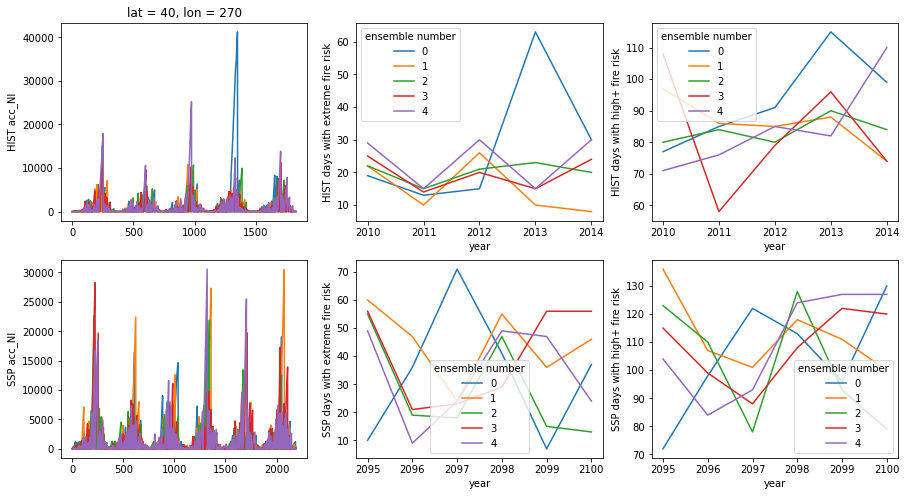

In [36]:
plt.figure(figsize=[15,8])
plt.subplot(2,3,1)
plt.plot(temp.transpose('time','ens')); 
plt.title('lat = '+str(plat)+', lon = '+str(plon))
plt.ylabel('HIST acc_NI');

plt.subplot(2,3,2)
exCount = temp.where(temp>4000).groupby('time.year').count(dim='time')
exCount.plot(hue='ens');
plt.ylabel('HIST days with extreme fire risk');

plt.subplot(2,3,3)
hiCount = temp.where(temp>1000).groupby('time.year').count(dim='time')
hiCount.plot(hue='ens');
plt.ylabel('HIST days with high+ fire risk');

plt.subplot(2,3,4)
plt.plot(tempSSP.transpose('time','ens')); 
plt.ylabel('SSP acc_NI');

plt.subplot(2,3,5)
exCount = tempSSP.where(tempSSP>4000).groupby('time.year').count(dim='time')
exCount.plot(hue='ens');
plt.ylabel('SSP days with extreme fire risk');

plt.subplot(2,3,6)
hiCount = tempSSP.where(tempSSP>1000).groupby('time.year').count(dim='time')
hiCount.plot(hue='ens');
plt.ylabel('SSP days with high+ fire risk');

### Sanity check, look at daily and accumulated NI for single ensemble member

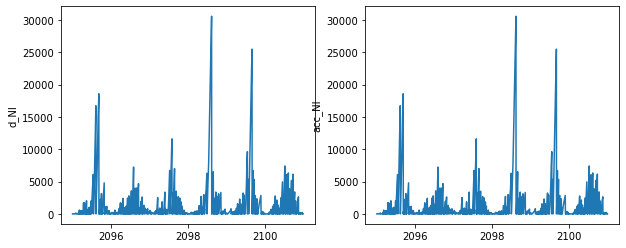

In [29]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(dsSSP.time, v)
plt.ylabel('d_NI')
plt.subplot(1,2,2)
plt.plot(dsSSP.time, result)
plt.ylabel('acc_NI');

In [28]:
print(ds.time['time'])

<xarray.DataArray 'time' (time: 1826)>
array([cftime.DatetimeGregorian(2010, 1, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2010, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2010, 3, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeGregorian(2161, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2162, 1, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2162, 2, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
    lon      float32 280.0
    lat      float32 47.59
  * time     (time) object 2010-01-01 00:00:00 ... 2162-02-01 00:00:00


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

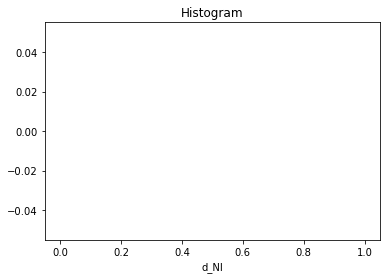

In [29]:
ds['d_NI'].isel(time=0,ens=0).plot()